<a href="https://colab.research.google.com/github/vikramkrishnan9885/MyColab/blob/master/AdvancedGluonTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ujson==1.35
!pip install spacy==2.0.18 folium==0.2.1 imgaug==0.2.7
!pip install --upgrade numpy
!pip install -q mxnet-cu101
!pip install gluonts

!nvcc --version

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
     |████████████████████████████████| 710.5MB 26kB/s 
     |████████████████████████████████| 419kB 6.5MB/s 
     |████████████████████████████████| 8.7MB 16.3MB/s 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

In [3]:
mx.random.seed(0)
np.random.seed(0)

GluonTS offers three different options to practitioners that want to experiment with the various modules:
* Use an available dataset provided by GluonTS
* Create an artificial dataset using GluonTS
* Convert your dataset to a GluonTS friendly format

In [4]:
!pip freeze | grep ujson

ujson==1.35


In [5]:
import json
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

# Create artificial datasets
We can easily create a complex artificial time series dataset using the ComplexSeasonalTimeSeries module.

In [6]:
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

In [7]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

In [8]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.freq}")

prediction length: 21
frequency: H


In [9]:
# The artificial dataset that we created is a list of dictionaries. 
# Each dictionary corresponds to a time series and it should contain the required fields.

print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item_id'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item_id'])


In [10]:
# In order to use the artificially created datasets (list of dictionaries) 
# we need to convert them to ListDataset objects.
train_ds = ListDataset(
    artificial_dataset.train,
    freq=artificial_dataset.metadata.freq
)

test_ds = ListDataset(
    artificial_dataset.test,
    freq=artificial_dataset.metadata.freq
)

train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

In [11]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

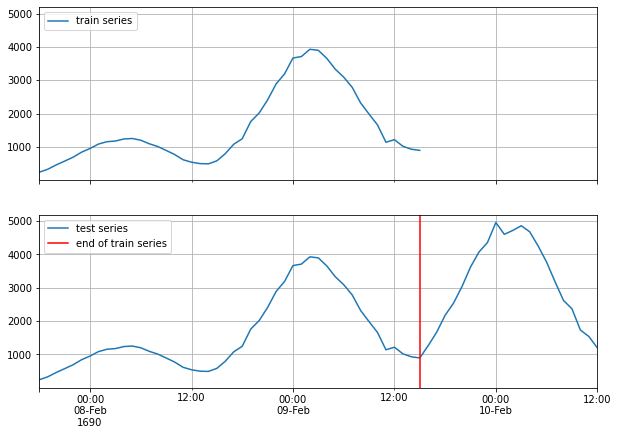

In [12]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [13]:
from gluonts.dataset.field_names import FieldName

In [14]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

The fields are split into three categories (__ROT__): the required ones, the optional ones, and the ones that can be added by the Transformation (explained in a while).

* Required:
  * start: start date of the time series
  * target: values of the time series
* Optional:
  * feat_static_cat: static (over time) categorical features, list with dimension equal to the number of features
  * feat_static_real: static (over time) real features, list with dimension equal to the number of features
  * feat_dynamic_cat: dynamic (over time) categorical features, array with shape equal to (number of features, target length)
  * feat_dynamic_real: dynamic (over time) real features, array with shape equal to (number of features, target length)
* Added by Transformation:
  * time_feat: time related features such as the month or the day
  * feat_dynamic_const: expands a constant value feature along the time axis
  * feat_dynamic_age: age feature, i.e., a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp
  * observed_values: indicator for observed values, i.e., a feature that equals to 1 if the value is observed and 0 if the value is missing
  * is_pad: indicator for each time step that shows if it is padded (if the length is not enough)
  * forecast_start: forecast start date

The dataset consists of a target, a real dynamic feature (which in this example we set to be the target value one period earlier), and a static categorical feature that indicates the sinusoid type (different phase) that we used to create the target.

In [15]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1),
                                      (int(np.ceil(num_series / 2)),1)),
                              np.tile(sin_Zero_2Pi.reshape(1, -1),
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                        target[:, :-period]
                                       ),
                                       axis=1
                                      )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )

    return target, feat_dynamic_real, feat_static_cat


# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }


data_out = create_dataset(custom_ds_metadata['num_series'],
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out

# We can easily create the train and test datasets by simply filling in the correct fields. 
# Remember that for the train dataset we need to cut the last window.

train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr],
                         FieldName.FEAT_STATIC_CAT: [fsc]}
                        for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
                                                             feat_static_cat)],
                      freq=custom_ds_metadata['freq'])

test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
                        FieldName.FEAT_STATIC_CAT: [fsc]}
                       for (target, start, fdr, fsc) in zip(target,
                                                            custom_ds_metadata['start'],
                                                            feat_dynamic_real,
                                                            feat_static_cat)],
                     freq=custom_ds_metadata['freq'])

* Now, we can examine each entry of the train and test datasets. 
* We should expect that they have the following fields: 
  * target, 
  * start, 
  * feat_dynamic_real and 
  * feat_static_cat.

In [16]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

In [17]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

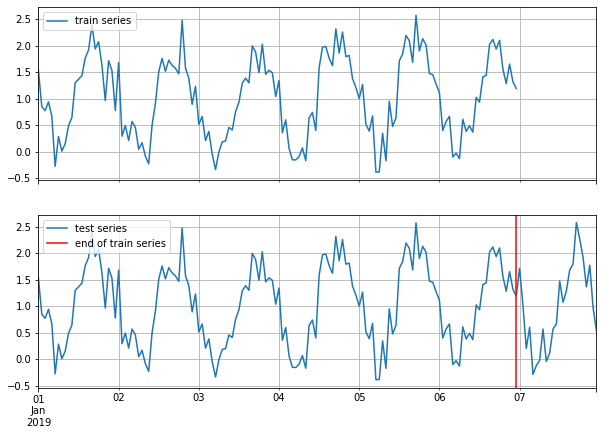

In [18]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

# Transformation

The primary use case for a Transformation is for __feature processing__, e.g., adding a holiday feature and for defining the way the dataset will be split into appropriate windows during training and inference.

In general, it __gets an iterable collection of entries of a dataset and transform it to another iterable collection that can possibly contain more fields__. The transformation is done by defining a set of __"actions"__ to the raw dataset depending on what is useful to our model.  As an example, in the following we add the following transformations:
* __AddObservedValuesIndicator__: Creates the observed_values field in the dataset, i.e., adds a feature that equals to 1 if the value is observed and 0 if the value is missing
* __AddAgeFeature__: Creates the feat_dynamic_age field in the dataset, i.e., adds a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp

The __Transformation__ may not define an additional field in the dataset. However, it __always__ needs to define how the datasets are going to be split in example windows during training and testing. This is done with the InstanceSplitter that is configured as follows (skipping the obvious fields):
* `is_pad_field`: indicator if the time series is padded (if the length is not enough)
* `train_sampler`: defines how the training windows are cut/sampled
* `time_series_fields`: contains the time dependent features that need to be split in the same manner as the target


In [19]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

In [20]:
transformation = create_transformation(custom_ds_metadata['freq'],
                                       2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
                                       custom_ds_metadata['prediction_length'])

When is_train=True in the transformation, the InstanceSplitter iterates over the transformed dataset and cuts windows by selecting randomly a time series and a starting point on that time series (this “randomness” is defined by the train_sampler).

In [21]:
train_tf = transformation(iter(train_ds), is_train=True)
type(train_tf)

generator

In [22]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

The transformer has done what we asked. In particular it has added:
* a field for observed values (`observed_values`)
* a field for the age feature (`feat_dynamic_age`)
* some extra useful fields (`past_is_pad`, `forecast_start`)

It has done one more important thing: it has split the window into past and future and has added the corresponding prefixes to all time dependent fields. This way we can easily use e.g., the `past_target` field as input and the `future_target` field to calculate the error of our predictions. Of course, the length of the past is equal to the `context_length` and of the future equal to the `prediction_length`

In [23]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


In [24]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source']

In [25]:
test_tf = transformation(iter(test_ds), is_train=False)
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [26]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (0,)
past observed values shape: (48,)
future observed values shape: (0,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


In [33]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 70.50it/s, epoch=5/5, avg_epoch_loss=0.604]


In [34]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [35]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [36]:
forecasts = list(forecast_it)
tss = list(ts_it)
tss

[                            0
 2019-01-01 00:00:00  1.529216
 2019-01-01 01:00:00  0.850250
 2019-01-01 02:00:00  0.774037
 2019-01-01 03:00:00  0.941432
 2019-01-01 04:00:00  0.672382
 ...                       ...
 2019-01-07 19:00:00  1.914151
 2019-01-07 20:00:00  1.363205
 2019-01-07 21:00:00  1.772893
 2019-01-07 22:00:00  0.969732
 2019-01-07 23:00:00  0.536569
 
 [168 rows x 1 columns],                             0
 2019-01-01 00:00:00  1.356409
 2019-01-01 01:00:00  0.825286
 2019-01-01 02:00:00  0.756674
 2019-01-01 03:00:00  0.364782
 2019-01-01 04:00:00  0.369164
 ...                       ...
 2019-01-07 19:00:00  1.531202
 2019-01-07 20:00:00  1.962812
 2019-01-07 21:00:00  1.164420
 2019-01-07 22:00:00  0.472045
 2019-01-07 23:00:00  1.181896
 
 [168 rows x 1 columns],                             0
 2019-01-01 00:00:00  0.473233
 2019-01-01 01:00:00  0.865484
 2019-01-01 02:00:00  0.275213
 2019-01-01 03:00:00  0.767029
 2019-01-01 04:00:00  0.432668
 ...              

In [37]:
# first entry of the time series list
ts_entry = tss[0]

# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

In [38]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

# first 5 values
test_ds_entry['target'][:5]

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

In [39]:
# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-01-07 00:00:00
Frequency of the time series: 1H


In [40]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 1.010157    0.69693625  0.53895813  0.17014767  0.04618827 -0.03344584
  0.07930034  0.11288085  0.19550577  0.57333446  0.549907    0.79348063
  1.1016355   1.3151007   1.4880301   1.8059026   2.0123706   2.1087887
  1.751892    1.5947442   1.7505257   1.2426538   1.1423274   1.0145165 ]
0.5-quantile (median) of the future window:
 [0.99757624 0.68248665 0.5009976  0.18920158 0.04634123 0.00625209
 0.05963631 0.09024727 0.2192874  0.533474   0.567426   0.8464734
 1.1004285  1.3207511  1.4701387  1.7942314  1.9720867  2.1027093
 1.7633646  1.6294644  1.7195903  1.2796788  1.1697702  1.0200057 ]


In [41]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

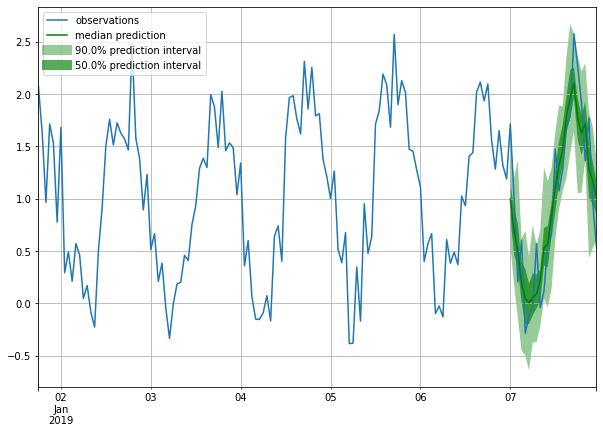

In [42]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [43]:
from gluonts.evaluation import Evaluator

In [44]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 3164.13it/s]


In [45]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.11134329497814179,
    "abs_error": 637.5226683616638,
    "abs_target_sum": 2505.765546798706,
    "abs_target_mean": 1.0440689778327943,
    "seasonal_error": 0.3378558193842571,
    "MASE": 0.7932630526420743,
    "MAPE": 2.1814811062887745,
    "sMAPE": 0.535017150398573,
    "OWA": NaN,
    "MSIS": 7.072284060426365,
    "QuantileLoss[0.1]": 281.159686344862,
    "Coverage[0.1]": 0.09958333333333337,
    "QuantileLoss[0.5]": 637.5226644352078,
    "Coverage[0.5]": 0.5058333333333335,
    "QuantileLoss[0.9]": 308.16382847242045,
    "Coverage[0.9]": 0.8766666666666666,
    "RMSE": 0.3336814273796817,
    "NRMSE": 0.31959710944799297,
    "ND": 0.25442231384182945,
    "wQuantileLoss[0.1]": 0.11220510502431623,
    "wQuantileLoss[0.5]": 0.25442231227486084,
    "wQuantileLoss[0.9]": 0.12298190821009639,
    "mean_wQuantileLoss": 0.16320310850309117,
    "MAE_Coverage": 0.009861111111111176
}


In [46]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.128362,7.511822,24.638548,1.026606,0.351642,0.890090,0.971391,0.688437,NaN,7.744248,2.613649,0.125000,7.511821,0.583333,3.514309,0.750000
1,NaN,0.093853,5.706580,22.178631,0.924110,0.340241,0.698839,1.130932,0.524796,NaN,6.439231,2.622835,0.083333,5.706580,0.750000,3.147576,0.875000
2,NaN,0.128940,6.430587,26.601139,1.108381,0.323560,0.828104,0.393957,0.529482,NaN,11.424002,3.234810,0.041667,6.430587,0.375000,4.025435,0.833333
3,NaN,0.108289,6.426091,22.502333,0.937597,0.311026,0.860873,1.176748,0.591845,NaN,6.660148,2.982630,0.166667,6.426091,0.666667,2.601714,0.958333
4,NaN,0.060962,4.492189,25.864388,1.077683,0.313119,0.597774,1.274738,0.435189,NaN,4.111522,2.435766,0.041667,4.492189,0.541667,2.480141,0.958333


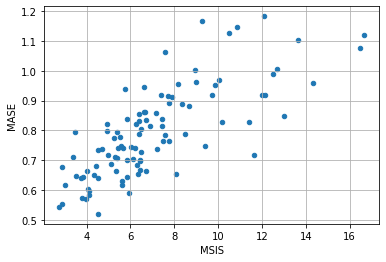

In [47]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()